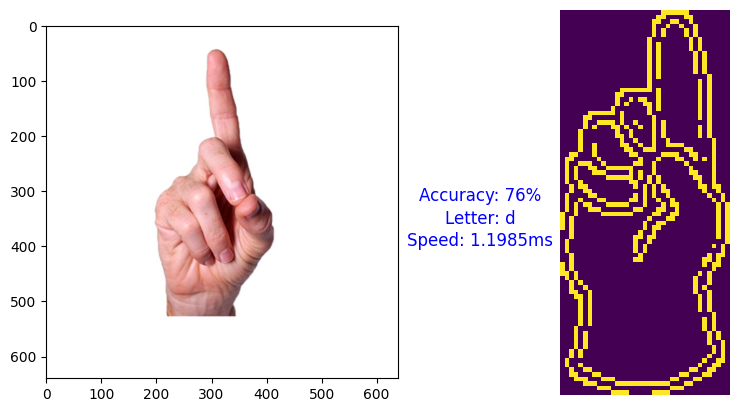

Letter detected from input image:  d


In [53]:
"""
Program Description: ISL-Recognition Program

Development Environment: This program was developed in Visual Studio Code.

Authors: Habeeb Alao, Oluwamayowa Adelaja, Ida Bamfi

Created: 25/10/2023    Modified: 30/11/2023
"""

import cv2
import numpy as np
from matplotlib import pyplot as plt 
import time



def preprocessing_and_feature_extraction(I: np.ndarray) -> np.ndarray:
    """
    Author: Habeeb Alao

    Outline of methods / algorithms used in preprocessing and feature extraction:

    Identification of Hand using skin detection:
        - This function looks for a hand in an input image using skin detection.
        - using predertmined color threshold values the skin region in the image is extracted.
        
    Gamma Correction:
        - This function applies a power transformation to adjust pixel values.
        - which effectivley modifies the relationship between the pixel values and the brightness to better match the characteristics of the display device or the human eye.
        
    Masking / Segmentation: 
        - This function uses the mask that got from performing skin detection to ectract the edges of the hand from the original rgb image.
        - with this we can see the isolated hand from the background

    Morphology (erosion, dialtion, opening and closing):
        -  Morphology is used in this function to remove excess mask info that may have been included after performing the inittail
        thresholding.
        - A variety of morphology techniques are used in this function including: erosion, dialtion, opening and closing. These techniques in conjunction 
        with eachother help refine the mask of the region of interest and remove excess binary pixles.
    
    Edge / Canny detection:
        - This function finds the edges of the hand using canny edge detection.

    Citations(IEEE format):

    [1]	S. Rahman, M. M. Rahman, M. Abdullah-Al-Wadud, G. D. Al-Quaderi, and M. Shoyaib, 
        “An adaptive gamma correction for image enhancement,” EURASIP J. Image Video Process., 
        vol. 2016, no. 1, p. 35, Oct. 2016, doi: 10.1186/s13640-016-0138-1.

    [2] W. Kubinger, M. Vincze, and M. Ayromlou, “The role of gamma correction in colour image processing,” 
        in 9th European Signal Processing Conference (EUSIPCO 1998), Sep. 1998, pp. 1-4. Accessed: Oct. 28, 2023. 
        [Online]. Available: https://ieeexplore.ieee.org/abstract/document/7090032

    [3] K. Nimisha and A. Jacob, “A Brief Review of the Recent Trends in Sign Language Recognition,” 
        in 2020 International Conference on Communication and Signal Processing (ICCSP), Jul. 2020, 
        pp. 186-190. doi: 10.1109/ICCSP48568.2020.9182351.

    [4] M. Safeel, T. Sukumar, S. K. S, A. M. D, S. R, and P. S. B, “Sign Language Recognition Techniques- A Review,”
        in 2020 IEEE International Conference for Innovation in Technology (INOCON), Nov. 2020, pp. 1-9. 
        doi: 10.1109/INOCON50539.2020.9298376.

    [5] D. Team, “Sign Language Recognition Using Python and OpenCV,” 
        DataFlair. Accessed: Oct. 04, 2023. [Online]. Available: https://data-flair.training/blogs/sign-language-recognition-python-ml-opencv/

    [6] M. Garimella, “Sign Language Recognition with Advanced Computer Vision,” 
        Medium. Accessed: Oct. 04, 2023. [Online]. Available: https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442

    """
    
    original_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

    # gamma correction on region of interest to enhance original color of hand
    gamma = 0.5
    copy_of_original = original_rgb.astype(float) / 255.0
    copy_of_original = np.power(copy_of_original, gamma)
    gamma_corrected_image = np.clip(copy_of_original * 255.0, 0, 255).astype(np.uint8)

    gamma_corrected_image_bgr = cv2.cvtColor(gamma_corrected_image, cv2.COLOR_RGB2BGR)

    # converting from bgr to YCbCr color space
    original_YCrCb = cv2.cvtColor(gamma_corrected_image_bgr, cv2.COLOR_BGR2YCrCb)

    # skin color range for hsv color space 
    YCrCb_mask = cv2.inRange(original_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    # erosion with rect shape
    shape = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask_erosion = cv2.erode(YCrCb_mask,shape)
    
    # dilation
    shape = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,2))
    dialated_mask = cv2.dilate(mask_erosion,shape)

    # opening
    shape = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,1))
    opened_mask = cv2.morphologyEx(dialated_mask,cv2.MORPH_OPEN,shape)

    # closing
    shape = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,5))
    closed_mask = cv2.morphologyEx(opened_mask,cv2.MORPH_CLOSE,shape)

    # extract skin region using cleaned mask
    skin_region = cv2.bitwise_and(original_rgb, original_rgb, mask = closed_mask)

    # extract edges of the input image
    edge_mask = cv2.Canny(skin_region,threshold1=220,threshold2=250)
    
    return edge_mask

def getting_template_images(I):
    """
    Author: Oluwamayowa Adelaja

    Outline of methods / algorithms used in getting template images features:


    ...

    """
    gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    # Apply thresholding or other preprocessing if needed
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours based on the y-coordinate of the bounding box
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])

    # Define a threshold for a new row
    row_threshold = 30

    # Group contours into rows
    rows = []
    current_row = [contours[0]]

    for i in range(1, len(contours)):
        x, y, w, h = cv2.boundingRect(contours[i])
        _, prev_y, _, _ = cv2.boundingRect(current_row[-1])

        # Check if a new row has started
        if abs(y - prev_y) > row_threshold:
            rows.append(current_row)
            current_row = []

        current_row.append(contours[i])

    # Add the last row
    rows.append(current_row)

    # Sort contours within each row based on x-coordinate
    for i, row in enumerate(rows):
        rows[i] = sorted(row, key=lambda c: cv2.boundingRect(c)[0])

    templates = []

    # Process each row
    for i, row in enumerate(rows):
        for j, contour in enumerate(row):
            if (i % 2 != 1):
                # Extract the letter image using the bounding box
                x, y, w, h = cv2.boundingRect(contour)
                letter_image = I[y:y+h, x:x+w]

                template = cv2.Canny(letter_image,threshold1=220,threshold2=250)

                templates.append(template)
                

    return templates

def template_matching(input_mask, templates):
    """
    Author: Ida Bamfi

    Outline of methods / algorithms used in template matching:
    ...

    """

    input_image = cv2.Canny(input_mask,threshold1=220,threshold2=250)
    best_match_score = -1


    best_match_index = 0
    for letter_index, template in enumerate(templates):
        # Apply template matching
        result = cv2.matchTemplate(input_image, template, cv2.TM_CCOEFF_NORMED)

        # Get the maximum correlation score and its location
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        # Check if this match is better than the previous best match
        if max_val > best_match_score:
            best_match_score = max_val
            best_template = template
            best_match_index = letter_index
        
    return (best_template, best_match_index, best_match_score)


def isl_detection(I: np.ndarray, T: np.ndarray):
    """

    Program Description: ISL-Recognition Program using:
        - preprocessing and feture extraction
        - template feature extraction 
        - template matching
    
    """

    alphabet = "abcdefghijklmnopqrstuvwxyz"
    original_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    start_time = time.time()
    
    # preprocessing and feture extraction 
    input_mask = preprocessing_and_feature_extraction(I)

    # template feature extraction
    templates = getting_template_images(T)

    # template matching
    isl_letter_template, letter_index, best_match_score = template_matching(input_mask, templates)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Set the figsize to your desired size
    axs[0].imshow(I)
    axs[1].imshow(isl_letter_template)

    execution_time = time.time() - start_time

    # Display the images with the same-sized axes
    axs[0].imshow(original_rgb)
    axs[1].text(-18, 40, 'Accuracy: '+str(int(round((1 - best_match_score) * 100))) +'%', ha='center', va='center', fontsize=12, color='blue')
    axs[1].text(-18, 45, 'Letter: '+ alphabet[letter_index], ha='center', va='center', fontsize=12, color='blue')
    axs[1].text(-18, 50, 'Speed: '+ str(round(execution_time, 4)) + 'ms', ha='center', va='center', fontsize=12, color='blue')
    axs[1].axis('off') 
    axs[1].imshow(isl_letter_template)

    plt.show()

    return alphabet[letter_index]
    

# image imports
input_image = cv2.imread('./sample-input.jpg')
template_image = cv2.imread('./isl-finger-sp.jpg')

# calling ISL detection function
detected_letter = isl_detection(input_image, template_image)

print("Letter detected from input image: ", detected_letter )